In [ ]:
!pip install pandas_ta
!pip install --upgrade xgboost

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
# --- Komórka 0: Importowanie bibliotek ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas_ta as ta

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from sklearn.pipeline import Pipeline

In [ ]:
# --- Komórka 1: Wczytywanie danych ---
# Wczytanie pliku CSV bez nagłówków i nadanie własnych nazw kolumn
df = pd.read_csv('AUDNZD_D1.csv', header=None,
                 names=['datetime', 'open', 'high', 'low', 'close', 'volume'])

# Konwersja kolumny datetime na format daty
df['datetime'] = pd.to_datetime(df['datetime'])

# Sprawdzenie podstawowych informacji o danych
print("Informacje o zbiorze danych:")
print(df.info())
print("\nPierwsze 5 wierszy:")
print(df.head())
print("\nOstatnie 3 wiersze:")
print(df.tail(3))
print("\nStatystyki opisowe:")
print(df.drop(['datetime'], axis=1).describe())

Informacje o zbiorze danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5017 entries, 0 to 5016
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  5017 non-null   datetime64[ns]
 1   open      5017 non-null   float64       
 2   high      5017 non-null   float64       
 3   low       5017 non-null   float64       
 4   close     5017 non-null   float64       
 5   volume    5017 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 235.3 KB
None

Pierwsze 5 wierszy:
    datetime     open     high      low    close  volume
0 2008-12-29  1.19102  1.19330  1.18430  1.18994    8363
1 2008-12-30  1.18864  1.20059  1.18340  1.19438   57481
2 2008-12-31  1.19318  1.21624  1.18867  1.21527   56691
3 2009-01-01  1.21026  1.21388  1.19905  1.20739   20521
4 2009-01-02  1.20757  1.21268  1.19419  1.21248   56036

Ostatnie 3 wiersze:
       datetime     open     high    

In [ ]:
df.head()

,datetime,open,high,low,close,volume
0,2008-12-29,1.19102,1.19330,1.18430,1.18994,8363
1,2008-12-30,1.18864,1.20059,1.18340,1.19438,57481
2,2008-12-31,1.19318,1.21624,1.18867,1.21527,56691
3,2009-01-01,1.21026,1.21388,1.19905,1.20739,20521
4,2009-01-02,1.20757,1.21268,1.19419,1.21248,56036


In [ ]:
# --- Komórka 2: Obliczanie EMA ---

def calculate_target(df, target_type=0):
    """
    Oblicza kolumnę target według wybranej metody:
    0 - prosty wzrost/spadek następnej świecy
    1 - wzrost/spadek z uwzględnieniem ATR
    2 - potwierdzenie wieloświecowe z wolumenem
    3 - przełamanie poziomów S/R
    """
    if target_type == 0:
        return (df['close'].shift(-1) > df['close']).astype(int)

    elif target_type == 1:
        atr = ta.atr(df['high'], df['low'], df['close'])
        next_close = df['close'].shift(-1)
        return ((next_close > df['close'] + (2 * atr)) |
                (next_close < df['close'] - atr)).astype(int)

    elif target_type == 2:
        future_close = df['close'].shift(-3)
        future_volume = df['volume'].shift(-3)
        return ((future_close > df['close']) &
                (future_volume > df['volume'])).astype(int)

    elif target_type == 3:
        lookback = 20
        future_bars = 3
        rolling_high = df['high'].rolling(lookback).max()
        rolling_low = df['low'].rolling(lookback).min()
        future_high = df['high'].shift(-future_bars).rolling(future_bars).max()
        future_low = df['low'].shift(-future_bars).rolling(future_bars).min()
        return ((df['close'] > rolling_high) & (future_high > rolling_high * 1.02) |
                (df['close'] < rolling_low) & (future_low < rolling_low * 0.98)).astype(int)


# Obliczanie wskaźników EMA dla różnych okresów
for period in [10, 20, 100, 200]:
    df[f'EMA_{period}'] = df['close'].ewm(span=period, adjust=False).mean()


# Dodanie kolumny target
target_type = 0  # Domyślna metoda
df['target'] = calculate_target(df, target_type)


# Dodanie kolumny target (1 jeśli następna świeca ma wyższą
# cenę zamknięcia, 0 jeśli niższą)
# df['target'] = (df['close'].shift(-1) > df['close']).astype(int)


In [ ]:
df[['EMA_10', 'EMA_20', 'EMA_100', 'EMA_200']].head()

,EMA_10,EMA_20,EMA_100,EMA_200
0,1.189940,1.189940,1.189940,1.189940
1,1.190747,1.190363,1.190028,1.189984
2,1.195206,1.192735,1.190528,1.190236
3,1.197421,1.194131,1.190862,1.190406
4,1.200159,1.195878,1.191290,1.190626


In [ ]:
# --- Komórka 3: Czyszczenie danych ---
# Usunięcie wierszy z brakującymi wartościami
df_cleaned = df.dropna()

# Sprawdzenie wierszy zduplikowanych i ich usunięcie
df_cleaned = df_cleaned.drop_duplicates()

# Sprawdzenie wartości odstających przy użyciu metody IQR
def remove_outliers(df, columns):
    """
    Funkcja usuwająca wartości odstające na podstawie metody IQR
    """
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numerical_columns = ['open', 'high', 'low', 'close', 'volume']
df_cleaned = remove_outliers(df_cleaned, numerical_columns)


In [ ]:
# --- Komórka 4: Inżynieria cech ---
# Dodanie nowych cech technicznych
df_cleaned['body'] = df_cleaned['close'] - df_cleaned['open']
df_cleaned['upper_shadow'] = df_cleaned['high'] - df_cleaned[['open', 'close']].max(axis=1)
df_cleaned['lower_shadow'] = df_cleaned[['open', 'close']].min(axis=1) - df_cleaned['low']
df_cleaned['daily_range'] = df_cleaned['high'] - df_cleaned['low']

# Dodanie wskaźników technicznych przy użyciu modułu pandas_ta
df_cleaned['RSI'] = ta.rsi(df_cleaned['close'], length=14)
macd = ta.macd(df_cleaned['close'])
df_cleaned['MACD'] = macd['MACD_12_26_9']
df_cleaned['MACD_Signal'] = macd['MACDs_12_26_9']
df_cleaned['MACD_Hist'] = macd['MACDh_12_26_9']

bb = ta.bbands(df_cleaned['close'], length=20)

df_cleaned['BB_Upper'] = bb['BBU_20_2.0']
df_cleaned['BB_Middle'] = bb['BBM_20_2.0']
df_cleaned['BB_Lower'] = bb['BBL_20_2.0']
df_cleaned['ADX'] = ta.adx(df_cleaned['high'], df_cleaned['low'], df_cleaned['close'])['ADX_14']
df_cleaned['OBV'] = ta.obv(df_cleaned['close'], df_cleaned['volume'])
df_cleaned['ATR'] = ta.atr(df_cleaned['high'], df_cleaned['low'], df_cleaned['close'])

df_cleaned = df_cleaned.dropna()



In [ ]:
# --- Komórka 5: Przygotowanie danych do modelowania ---
# Wybór cech do modelowania
features = ['open', 'high', 'low', 'close', 'volume',
           'EMA_10', 'EMA_20', 'EMA_100', 'EMA_200',
           'body', 'upper_shadow', 'lower_shadow', 'daily_range',
           'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist',
           'BB_Upper', 'BB_Middle', 'BB_Lower', 'ADX', 'OBV', 'ATR']

X = df_cleaned[features]
y = df_cleaned['target']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


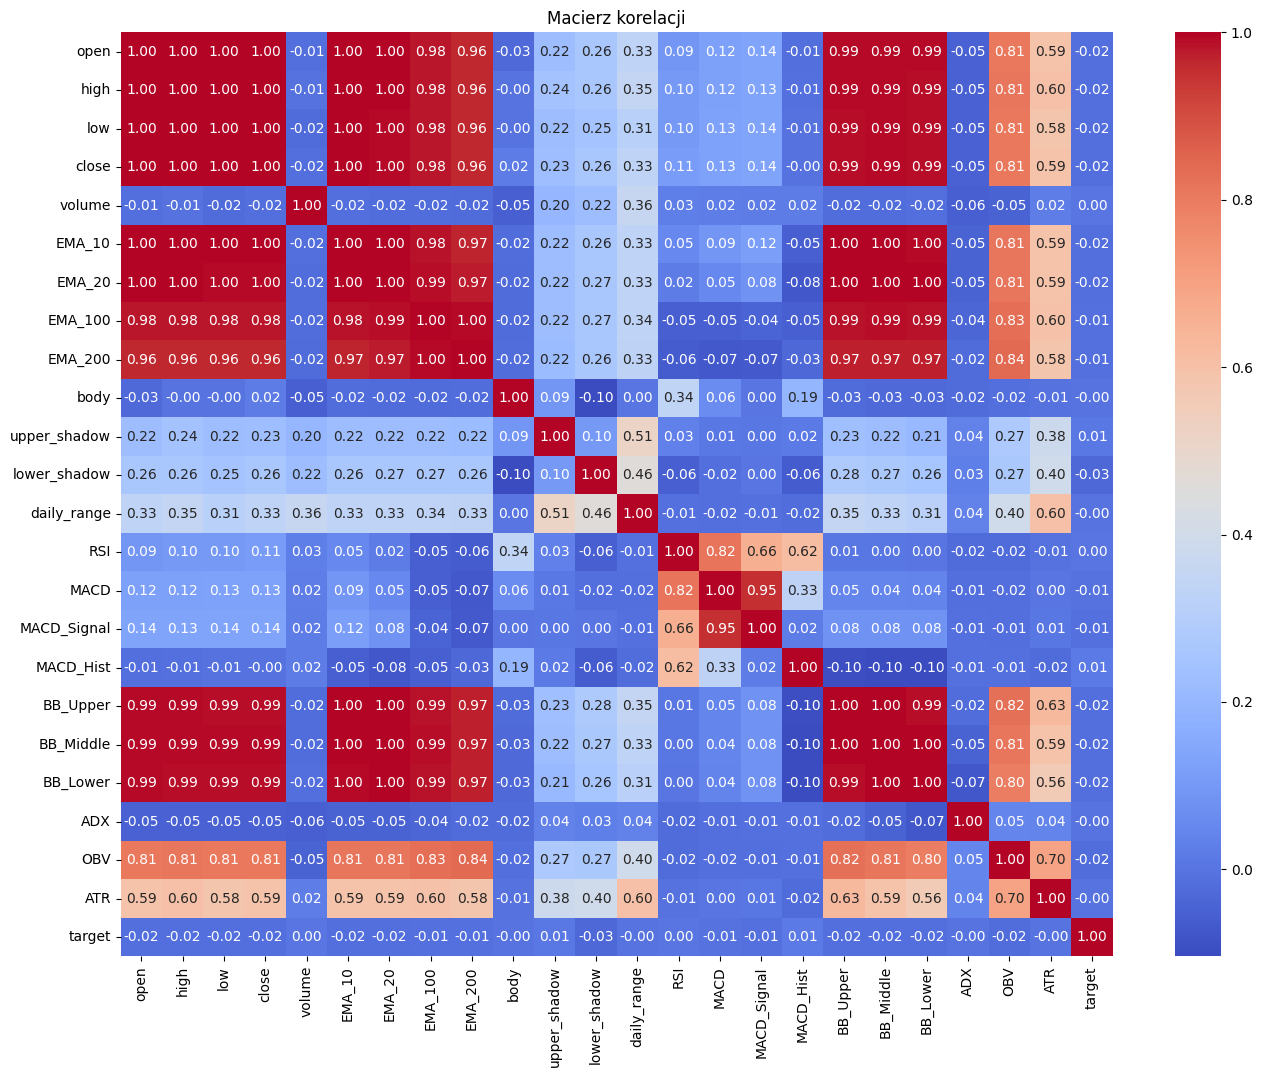


Korelacja cech z targetem:
 open           -0.015919
high           -0.015612
low            -0.015647
close          -0.016068
volume          0.000295
EMA_10         -0.015952
EMA_20         -0.015879
EMA_100        -0.013119
EMA_200        -0.012134
body           -0.003111
upper_shadow    0.008875
lower_shadow   -0.033093
daily_range    -0.004383
RSI             0.000677
MACD           -0.007788
MACD_Signal    -0.012464
MACD_Hist       0.012793
BB_Upper       -0.016144
BB_Middle      -0.016219
BB_Lower       -0.016216
ADX            -0.002611
OBV            -0.020872
ATR            -0.003423
Name: target, dtype: float64


In [ ]:
# --- Komórka 5.5: Analiza korelacji ---
# Obliczenie macierzy korelacji
correlation_matrix = df_cleaned[features + ['target']].corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(16, 12))  # Zwiększenie rozmiaru wykresu
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji')
plt.show()

# Wyświetlenie korelacji cech z targetem
target_correlations = correlation_matrix['target'].drop('target')  # Usunięcie korelacji targetu z samym sobą
print("\nKorelacja cech z targetem:\n", target_correlations)

In [ ]:
# --- Komórka 6: Trenowanie modeli bazowych ---
# Lista modeli do trenowania
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'SVM': SVC(probability=True, random_state=42),
    'kNN': KNeighborsClassifier()
}

# Słownik na wyniki
results = {}

# Trenowanie i ewaluacja każdego modelu
for name, model in models.items():
    # Trenowanie modelu
    model.fit(X_train_scaled, y_train)

    # Predykcje
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Zapisanie wyników
    results[name] = {
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    # Wydruk raportu klasyfikacji
    print(f"\nWyniki dla modelu {name}:")
    print(classification_report(y_test, y_pred))



Wyniki dla modelu Logistic Regression:
              precision    recall  f1-score   support

           0       0.49      0.37      0.42       470
           1       0.53      0.65      0.58       507

    accuracy                           0.51       977
   macro avg       0.51      0.51      0.50       977
weighted avg       0.51      0.51      0.50       977


Wyniki dla modelu Random Forest:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       470
           1       0.55      0.57      0.56       507

    accuracy                           0.54       977
   macro avg       0.54      0.54      0.54       977
weighted avg       0.54      0.54      0.54       977



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:30:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Wyniki dla modelu XGBoost:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51       470
           1       0.54      0.51      0.53       507

    accuracy                           0.52       977
   macro avg       0.52      0.52      0.52       977
weighted avg       0.52      0.52      0.52       977


Wyniki dla modelu SVM:
              precision    recall  f1-score   support

           0       0.51      0.43      0.47       470
           1       0.54      0.61      0.57       507

    accuracy                           0.52       977
   macro avg       0.52      0.52      0.52       977
weighted avg       0.52      0.52      0.52       977


Wyniki dla modelu kNN:
              precision    recall  f1-score   support

           0       0.48      0.49      0.48       470
           1       0.52      0.51      0.51       507

    accuracy                           0.50       977
   macro avg       0.50      0.50      0.50       97

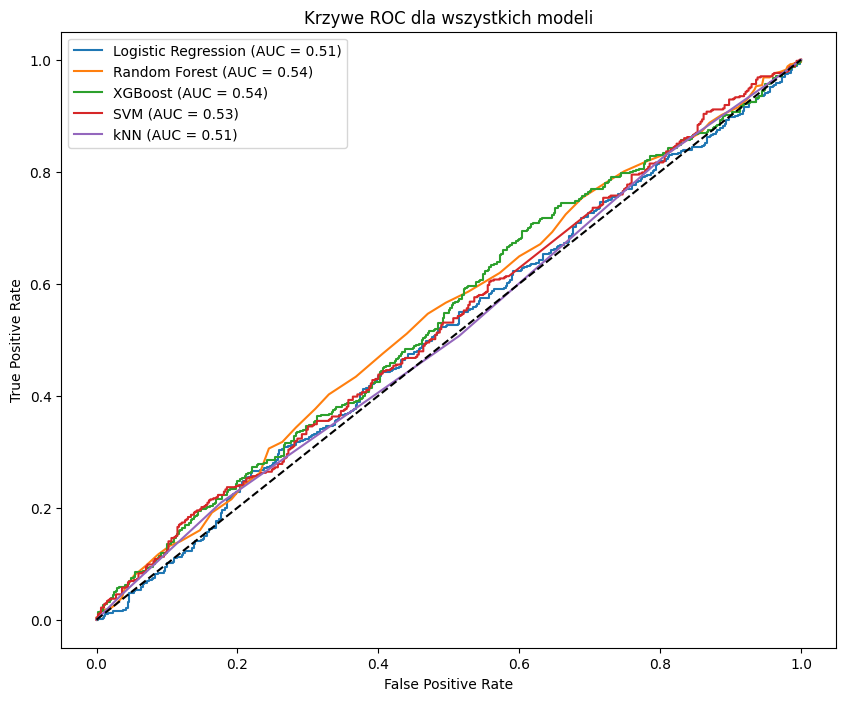

In [ ]:
# --- Komórka 7: Wizualizacja wyników ---
def plot_roc_curves(results, y_test):
    """
    Funkcja rysująca krzywe ROC dla wszystkich modeli
    """
    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Krzywe ROC dla wszystkich modeli')
    plt.legend()
    plt.show()

# Rysowanie krzywych ROC
plot_roc_curves(results, y_test)


In [ ]:
# --- Komórka 8: Strojenie hiperparametrów ---
# Definicja przestrzeni parametrów dla każdego modelu
models1 = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'kNN': KNeighborsClassifier()
}
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2', None]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10]
    },
        'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    'kNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}
    # Osobne strojenie dla XGBoost
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300]
}

best_models = {}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
# Konwersja danych do DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Parametry do przeszukania
params_list = [
    {'max_depth': depth, 'eta': lr, 'n_estimators': n_est}
    for depth in [3, 5, 7]
    for lr in [0.01, 0.1, 0.3]
    for n_est in [100, 200, 300]
]

# Ocena każdej kombinacji parametrów
best_score = 0
best_params = None
best_model = None

for params in params_list:
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=params['n_estimators'],
        evals=[(dtest, 'test')],
        verbose_eval=False
    )
    pred_probs = model.predict(dtest)
    score = roc_auc_score(y_test, pred_probs)

    if score > best_score:
        best_score = score
        best_params = params
        best_model = model

best_models['XGBoost'] = best_model
print(f"\nNajlepsze parametry XGBoost: {best_params}")


print(f"\nNajlepsze parametry XGBoost:")
print(f"Najlepszy wynik ROC AUC: {best_score:.4f}")



# Przeprowadzenie strojenia dla każdego modelu
for name, model in models1.items():
    print(f"\nStrojenie parametrów dla modelu {name}")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    print(f"Najlepsze parametry: {grid_search.best_params_}")
    print(f"Najlepszy wynik: {grid_search.best_score_:.4f}")

    best_models[name] = grid_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:30:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:30:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:30:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:30:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:30:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.




Najlepsze parametry XGBoost: {'max_depth': 7, 'eta': 0.3, 'n_estimators': 200}

Najlepsze parametry XGBoost:
Najlepszy wynik ROC AUC: 0.5538

Strojenie parametrów dla modelu Logistic Regression
Najlepsze parametry: {'C': 10, 'penalty': 'l2'}
Najlepszy wynik: 0.5097

Strojenie parametrów dla modelu Random Forest
Najlepsze parametry: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Najlepszy wynik: 0.5367

Strojenie parametrów dla modelu SVM
Najlepsze parametry: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Najlepszy wynik: 0.5147

Strojenie parametrów dla modelu kNN
Najlepsze parametry: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Najlepszy wynik: 0.4898



Końcowe wyniki dla modelu XGBoost:
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       470
           1       0.55      0.53      0.54       507

    accuracy                           0.53       977
   macro avg       0.53      0.53      0.53       977
weighted avg       0.54      0.53      0.53       977


Końcowe wyniki dla modelu Logistic Regression:
              precision    recall  f1-score   support

           0       0.48      0.36      0.41       470
           1       0.52      0.64      0.57       507

    accuracy                           0.51       977
   macro avg       0.50      0.50      0.49       977
weighted avg       0.50      0.51      0.50       977


Końcowe wyniki dla modelu Random Forest:
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       470
           1       0.54      0.58      0.56       507

    accuracy                           0.53       977
  

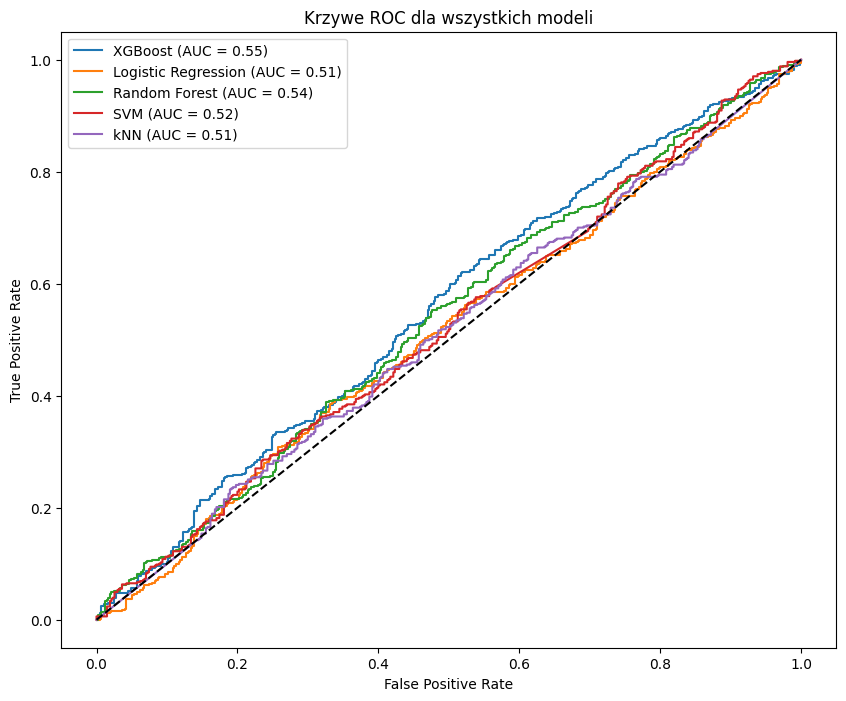

In [ ]:
# --- Komórka 9: Ewaluacja najlepszych modeli ---
# Słownik na końcowe wyniki
final_results = {}

dtest = xgb.DMatrix(X_test_scaled)

for name, model in best_models.items():
    # Predykcje
    if name == 'XGBoost':
        y_pred = (model.predict(dtest) > 0.5).astype(int)  # Binary predictions
        y_pred_proba = model.predict(dtest)
    else:
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Zapisanie wyników
    final_results[name] = {
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    # Wydruk raportu klasyfikacji
    print(f"\nKońcowe wyniki dla modelu {name}:")
    print(classification_report(y_test, y_pred))

# Rysowanie końcowych krzywych ROC
plot_roc_curves(final_results, y_test)


In [ ]:
# --- Komórka 10: Tworzenie potoku ---
# Utworzenie potoku z najlepszym modelem

def xgb_pipeline(X_train, y_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(X_test_scaled)

    model = xgb.train(params={}, dtrain=dtrain)
    #return model.predict(dtest)
    return (model.predict(dtest) > 0.5).astype(int)


best_model_name = max(final_results.keys(), key=lambda k: roc_auc_score(y_test, final_results[k]['probabilities']))
best_model = best_models[best_model_name]

if best_model_name == 'XGBoost':
    pipeline = xgb_pipeline
else:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', best_model)
    ])
    pipeline.fit(X_train, y_train)


if best_model_name != 'XGBoost':
  y_pred_pipeline = pipeline.fit(X_train, y_train)
else:
  y_pred_pipeline = pipeline(X_train, y_train, X_test)


print("\nWyniki końcowe dla pipeline'u:")
print(classification_report(y_test, y_pred_pipeline))

import joblib
# Zapisanie pipeline'u
if best_model_name != 'XGBoost':
    joblib.dump(pipeline, 'candlestick_classification_pipeline.joblib')



#if (best_model_name == 'XGBoost'):
#    y_pred_pipeline = xgb_pipeline(X_train, y_train, X_test)
#else:
#    y_pred_pipeline = best_model.predict(X_test)

#pipeline = Pipeline([
#    ('scaler', StandardScaler()),
#    ('classifier', best_model)
#])

print(type(y_pred_pipeline))




# Trening i ewaluacja potoku
#pipeline.fit(X_train, y_train)
#y_pred_pipeline = pipeline.predict(X_test)

#print("\nWyniki końcowe dla pipeline'u:")
#print(classification_report(y_test, y_pred_pipeline))

# Zapisanie pipeline'u
#import joblib
#joblib.dump(pipeline, 'candlestick_classification_pipeline.joblib')



Wyniki końcowe dla pipeline'u:
              precision    recall  f1-score   support

           0       0.48      0.45      0.47       470
           1       0.52      0.55      0.53       507

    accuracy                           0.50       977
   macro avg       0.50      0.50      0.50       977
weighted avg       0.50      0.50      0.50       977

<class 'numpy.ndarray'>


In [ ]:
# --- CELL 11: Przykład użycia pipeline'u ---
# Załadowanie nowych danych
new_data = pd.read_csv('AUDUSD_D1.csv', header=None,
                       names=['datetime', 'open', 'high', 'low', 'close', 'volume'])

# Przygotowanie cech
# (tutaj należy dodać ten sam preprocessing co wcześniej)

# Predykcja

#if best_model_name == 'XGBoost':
#    predictions = xgb_pipeline(X_train, y_train, new_data[features])
#else:
#    predictions = pipeline.predict(new_data[features])
#    probabilities = pipeline.predict_proba(new_data[features])
#
#print("\nPrzykładowe predykcje dla nowych danych:")
#print(predictions[:10])


